**실습 목표**
1. MNIST 데이터셋을 PCA를 통해 차원축소하여 분류 모델 성능 향상에 이용해보자
2. MNIST 데이터셋을 다양한 특징 추출 기법으로 차원축소하여 시각화해보자

In [ ]:
import numpy as np
import pandas as pd
import os
import time
import pickle
import gzip

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
%matplotlib inline

from sklearn.metrics import accuracy_score, f1_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# MNIST dataset
- 0~9까지의 숫자를 손으로 쓴 이미지 파일
- 28*28 pixel (=784 차원)
- train, validation, test 데이터셋이 각각 50000, 10000, 10000개
- 시간이 오래 걸리므로 예시에서는 train 5000개, test 1000개 가지고만 진행


In [ ]:
f=gzip.open('/content/drive/MyDrive/DSL 2023-1/차원축소 세션 준비/mnist.pkl.gz', 'rb')

train_set, validation_set, test_set = pickle.load(f, encoding='latin1')
f.close()

X_train, y_train = train_set[0], train_set[1]
X_validation, y_validation = validation_set[0], validation_set[1]
X_test, y_test = test_set[0], test_set[1]

In [ ]:
# Pandas dataframe 생성하기
train_index = range(0, len(X_train))
validation_index = range(len(X_train), len(X_train) + len(X_validation))
test_index = range(len(X_train)+len(X_validation),
                   len(X_train)+len(X_validation)+len(X_test))

X_train = pd.DataFrame(data=X_train, index=train_index)
y_train = pd.Series(data=y_train, index=train_index)

X_validation = pd.DataFrame(data=X_validation, index=validation_index)
y_validation = pd.Series(data=y_validation, index=validation_index)

X_test = pd.DataFrame(data=X_test, index=test_index)
y_test = pd.Series(data=y_test, index=test_index)

print(X_train.shape)
print(X_validation.shape)
print(X_test.shape)

(50000, 784)
(10000, 784)
(10000, 784)


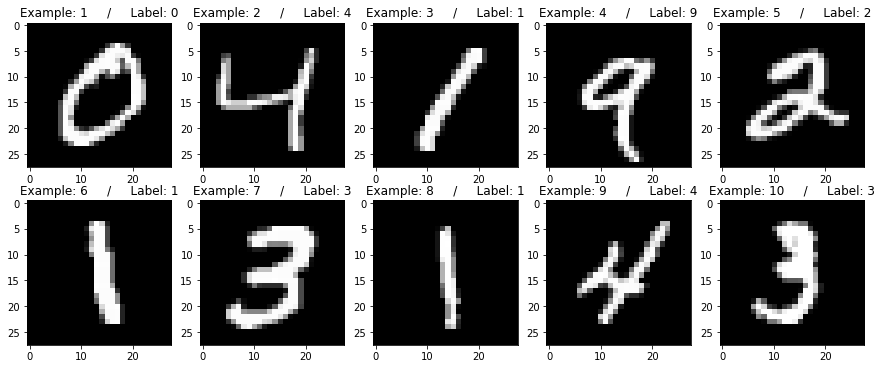

In [ ]:
#데이터셋 미리 보기
plt.figure(figsize=(15,6))
for i in range(1,11):
  plt.subplot(2,5,i)
  label = y_train.loc[i]
  image = X_train.loc[i,:].values.reshape([28, 28])
  plt.imshow(image, cmap=plt.get_cmap('gray'))
  plt.title('Example: %d     /     Label: %d'%(i, label))

plt.show()

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


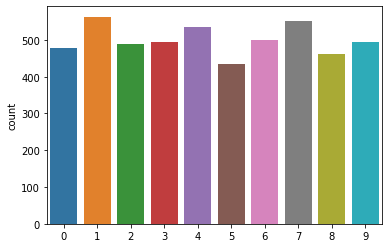

In [ ]:
#train dataset으로 5000개만 사용
X_train=X_train.loc[:4999,:]
y_train=y_train[:5000]
sns.countplot(y_train) #y라벨이 균등하게 분포하는지 확인
plt.show()

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


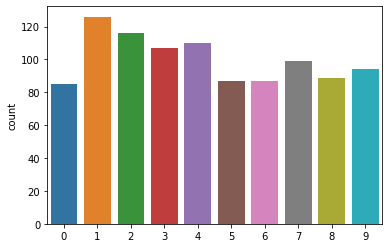

In [ ]:
#test dataset으로 1000개만 사용
X_test=X_test.loc[60000:60999,:]
y_test=y_test[:1000]
sns.countplot(y_test)
plt.show()

In [ ]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(5000, 784) (5000,) (1000, 784) (1000,)


#  PCA를 이용해 모델 성능 높이기
- MNIST 데이터셋 분류 모델을 만들어보자 (with logistic regression, DT, ensemble, ...)
- original space(784차원)을 그대로 대입했을때 분류 성능, 학습 속도 측정해보기
- PCA를 통해서 차원 축소를 한 이후 분류 성능, 학습 속도 측정해보기

In [ ]:
from sklearn.decomposition import PCA
pca=PCA(n_components=784) #784차원의 잠재변수
X_train_PCA=pca.fit_transform(X_train)
X_train_PCA.shape

(5000, 784)

## 몇개의 주성분을 사용할 것인가?
- 합리적인 차원을 찾기 위하여 PCA 이후 각각의 주성분(잠재변수)들이 설명하는 분산이 어느정도 되는지 알아보자
- original data의 분산 중 최소한 80%는 설명가능하려면 차원을 몇으로 축소해야되는가? (= 몇개의 잠재변수를 사용해야하는가?)

In [ ]:
pca.explained_variance_ratio_[:10]

array([0.09867552, 0.07404552, 0.06127707, 0.05405313, 0.04737569,
       0.04419002, 0.03370106, 0.02912436, 0.0277273 , 0.02330224],
      dtype=float32)

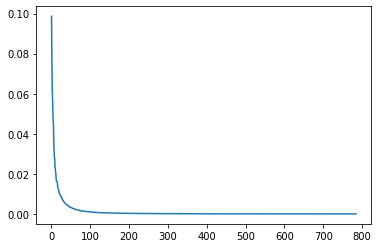

In [ ]:
plt.plot(range(1,785),pca.explained_variance_ratio_)
plt.show()

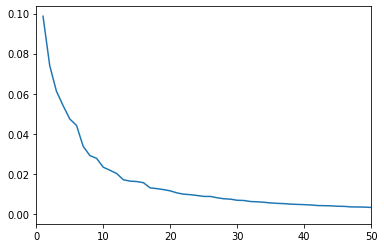

In [ ]:
plt.plot(range(1,785),pca.explained_variance_ratio_)
plt.xlim(0,50)
plt.show()

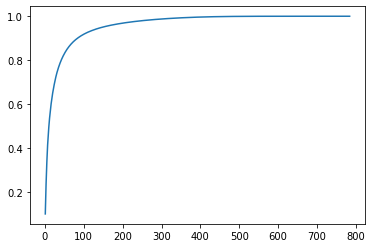

In [ ]:
cumulative = []
temp = 0
for i in range(0, 784):
    temp += pca.explained_variance_ratio_[i]
    cumulative.append(temp)

plt.plot(range(1,785),cumulative)
plt.show()

In [ ]:
for i in [10,20,50,100,784]:
  explained=np.sum(pca.explained_variance_ratio_[:i])
  print(i,'개의 잠재변수가 설명하는 분산은 전체 데이터의 {:.2f}%'.format(explained*100))

10 개의 잠재변수가 설명하는 분산은 전체 데이터의 49.35%
20 개의 잠재변수가 설명하는 분산은 전체 데이터의 64.98%
50 개의 잠재변수가 설명하는 분산은 전체 데이터의 82.91%
100 개의 잠재변수가 설명하는 분산은 전체 데이터의 91.80%
784 개의 잠재변수가 설명하는 분산은 전체 데이터의 100.00%


In [ ]:
cumulative=np.array(cumulative)
np.where(cumulative>0.8)[0][0] #42개 쓰면 분산의 80%이상을 설명

42

## PCA를 통한 특징 추출 이후 성능 확인

In [ ]:
#pca를 통한 특징 추출 과정에서는 y라벨을 사용하지X(unsupervised)
#성능 확인 과정에서 y라벨이 사용됨
pca=PCA(n_components=42)
X_train_PCA=pca.fit_transform(X_train) #train은 fit + transform
X_test_PCA=pca.transform(X_test)       #test는 transform
print('Original space:',X_train.shape)
print('After PCA:',X_train_PCA.shape)

Original space: (5000, 784)
After PCA: (5000, 42)


### 1. Logistic regression

In [ ]:
#차원축소 이전(origianl 공간 784차원)
start=time.time()
logistic_original=LogisticRegression(max_iter=1000) #warning 메시지가 나와서 max_iter 지정해줌
logistic_original.fit(X_train,y_train)  #train set만 고려
print('train accuracy:',accuracy_score(y_train, logistic_original.predict(X_train)))
print('test accuracy:',accuracy_score(y_test, logistic_original.predict(X_test)))
print(f'{time.time()-start:.4f}sec')

train accuracy: 0.9878
test accuracy: 0.883
20.2890sec


In [ ]:
#차원축소 이후(42차원)
start=time.time()
logistic_pca=LogisticRegression(max_iter=1000) 
logistic_pca.fit(X_train_PCA,y_train)
print('train accuracy:',accuracy_score(y_train, logistic_pca.predict(X_train_PCA)))
print('test accuracy:',accuracy_score(y_test, logistic_pca.predict(X_test_PCA)))
print(f'{time.time()-start:.4f}sec')

train accuracy: 0.923
test accuracy: 0.878
0.7861sec


- PCA 이후 학습 속도 개선
- PCA 이전과 이후에 train accuracy는 차이가 많이 나지만, test accuracy는 거의 유사하다. PCA 이전 고차원 공간에서는 학습데이터에 과적합된 것으로 보인다.
- 더 빠른 학습 속도로 비슷한 성능을 보인다.

### 2. Random Forest

In [ ]:
#차원축소 이전(784차원)
start=time.time()
rf_original=RandomForestClassifier()
rf_original.fit(X_train,y_train)
print('train accuracy:',accuracy_score(y_train, rf_original.predict(X_train)))
print('test accuracy:',accuracy_score(y_test, rf_original.predict(X_test)))
print(f'{time.time()-start:.4f}sec')

train accuracy: 1.0
test accuracy: 0.918
3.9350sec


In [ ]:
#차원축소 이후(42차원)
start=time.time()
rf_pca=RandomForestClassifier()
rf_pca.fit(X_train_PCA, y_train)
print('train accuracy:',accuracy_score(y_train, rf_pca.predict(X_train_PCA)))
print('test accuracy:',accuracy_score(y_test, rf_pca.predict(X_test_PCA)))
print(f'{time.time()-start:.4f}sec')

train accuracy: 1.0
test accuracy: 0.897
3.2055sec


- 차원축소 이후 학습속도 감소가 크게 감소하지는 않음.(병렬적 학습이기 때문에 애초에 학습속도가 그렇게 느리지 않음)
- 성능 역시 PCA 이전이 미세하게 더 높음.
- random forest의 경우 decision tree를 병렬적으로 여러개 사용하면서 DT가 야기할 수 있는 과적합 문제를 이미 어느정도는 해결하고 있는 앙상블 기법이므로 PCA를 통해 더 개선되지X
- 무조건 차원축소가 올바른 전처리 방법은 아니다. 과적합이나 다중공선성이 critical한 문제로 인식될 때 써볼 수 있는 하나의 방법 중 하나. 

### 3. XGBoost

In [ ]:
#차원축소 이전
from xgboost import XGBClassifier
start=time.time()
xgboost_original = XGBClassifier()
xgboost_original.fit(X_train, y_train)
print('train accuracy:',accuracy_score(y_train, xgboost_original.predict(X_train)))
print('test accuracy:',accuracy_score(y_test, xgboost_original.predict(X_test)))
print(f'{time.time()-start:.4f}sec')

train accuracy: 0.9878
test accuracy: 0.888
120.8316sec


In [ ]:
#차원축소 이후
start=time.time()
xgboost_pca = XGBClassifier()
xgboost_pca.fit(X_train_PCA, y_train)
print('train accuracy:',accuracy_score(y_train, xgboost_pca.predict(X_train_PCA)))
print('test accuracy:',accuracy_score(y_test, xgboost_pca.predict(X_test_PCA)))
print(f'{time.time()-start:.4f}sec')

train accuracy: 0.9734
test accuracy: 0.876
17.2932sec


- 차원축소 이후 학습속도 감소가 크게 감소함.(순차적 학습이기 때문에 속도 크게 감소)
- 더 빠른 속도로 비슷한 성능

# 2차원에 시각화

## PCA
- 분산을 크게하는 잠재변수를 찾자

In [ ]:
start=time.time()
pca=PCA(n_components=2)
X_train_PCA=pca.fit_transform(X_train) 
print(f'{time.time()-start:.4f}sec')

0.3561sec


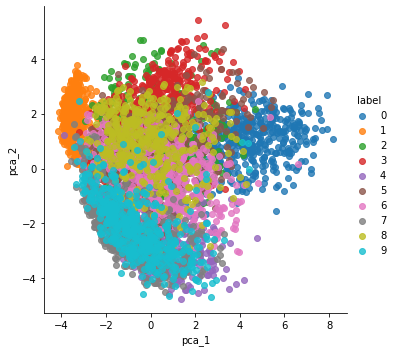

In [ ]:
X_train_pca=pd.DataFrame(X_train_PCA).loc[:,0:1]
X_train_pca=pd.concat((X_train_pca, y_train), axis=1) 
X_train_pca.columns=['pca_1', 'pca_2', 'label']

sns.lmplot(x='pca_1',y='pca_2',data=X_train_pca,hue='label',fit_reg=False)
plt.show()

## MDS
- 고차원에서의 거리 정보를 최대한 유지하는 저차원의 공간을 찾자

In [ ]:
#시간 엄청 오래 걸림
from sklearn.manifold import MDS
start=time.time()
mds = MDS(n_components=2, random_state=42)
X_train_mds = mds.fit_transform(X_train)
print(f'{time.time()-start:.4f}sec')

726.3932sec


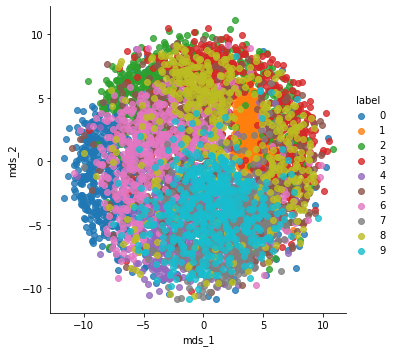

In [ ]:
X_train_mds=pd.DataFrame(X_train_mds).loc[:,0:1]
X_train_mds=pd.concat((X_train_mds, y_train), axis=1) 
X_train_mds.columns=['mds_1', 'mds_2', 'label']
X_train_mds

sns.lmplot(x='mds_1',y='mds_2',data=X_train_mds,hue='label',fit_reg=False)
plt.show()

## LDA
- class(label)을 잘 구분해주는 축을 찾자

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
start=time.time()
lda = LinearDiscriminantAnalysis(n_components=2)
X_train_lda = lda.fit_transform(X_train, y_train) #차원축소 과정에 y라벨값을 입력해줌
print(f'{time.time()-start:.4f}sec')

3.3277sec


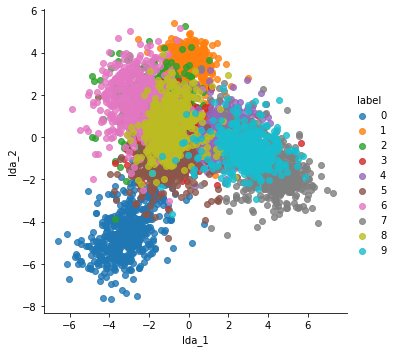

In [ ]:
X_train_lda=pd.DataFrame(X_train_lda).loc[:,0:1]
X_train_lda=pd.concat((X_train_lda, y_train), axis=1) 
X_train_lda.columns=['lda_1', 'lda_2', 'label']
X_train_lda

sns.lmplot(x='lda_1',y='lda_2',data=X_train_lda,hue='label',fit_reg=False)
plt.show()

## KPCA
- 고차원에서 분산을 크게 해주는 축을 찾자
- 데이터의 형태에 따라 적절한 커널 및 하이퍼파라미터을 사용해줄 필요 있음.

In [ ]:
from sklearn.decomposition import KernelPCA
start=time.time()
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433, fit_inverse_transform=True) #방사형 커널 사용
X_train_rbf_pca=rbf_pca.fit_transform(X_train)
print(f'{time.time()-start:.4f}sec')

8.6552sec


In [ ]:
start=time.time()
sig_pca = KernelPCA(n_components = 2, kernel="sigmoid", gamma=0.001, coef0=1, fit_inverse_transform=True) #시그모이드 커널 사용
X_train_sig_pca=sig_pca.fit_transform(X_train)
#X_test_rbf_pca=sig_pca.fit_transform(X_test)
print(f'{time.time()-start:.4f}sec')

7.7767sec


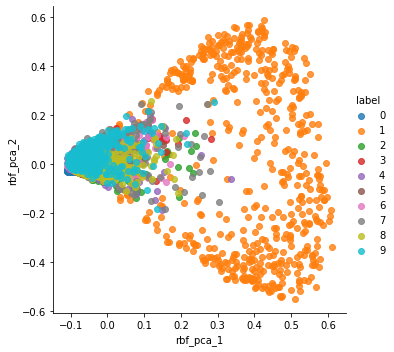

In [ ]:
X_train_rbf_pca=pd.DataFrame(X_train_rbf_pca).loc[:,0:1]
X_train_rbf_pca=pd.concat((X_train_rbf_pca, y_train), axis=1) 
X_train_rbf_pca.columns=['rbf_pca_1', 'rbf_pca_2', 'label']

sns.lmplot(x='rbf_pca_1',y='rbf_pca_2',data=X_train_rbf_pca,hue='label',fit_reg=False)
plt.show()

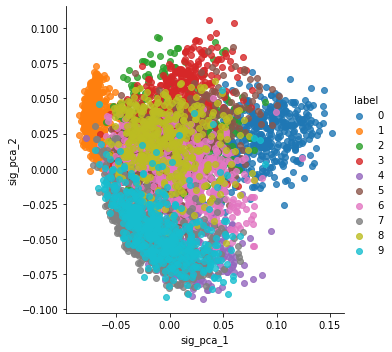

In [ ]:
X_train_sig_pca=pd.DataFrame(X_train_sig_pca).loc[:,0:1]
X_train_sig_pca=pd.concat((X_train_sig_pca, y_train), axis=1) 
X_train_sig_pca.columns=['sig_pca_1', 'sig_pca_2', 'label']

sns.lmplot(x='sig_pca_1',y='sig_pca_2',data=X_train_sig_pca,hue='label',fit_reg=False)
plt.show()

## ISOMAP
- 지오데식 거리를 최대한 보존하는 저차원의 공간을 찾자

In [ ]:
from sklearn.manifold import Isomap
start=time.time()
isomap=Isomap(n_neighbors=5,n_components=2,n_jobs=4)         
X_train_isomap=isomap.fit_transform(X_train)
print(f'{time.time()-start:.4f}sec')

27.1176sec


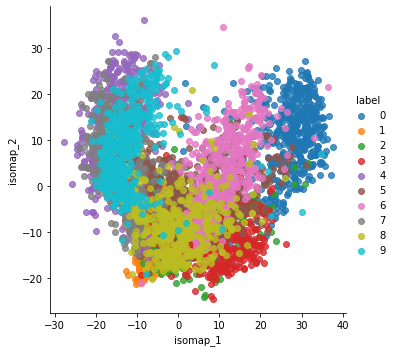

In [ ]:
X_train_isomap=pd.DataFrame(X_train_isomap).loc[:,0:1]
X_train_isomap=pd.concat((X_train_isomap, y_train), axis=1) 
X_train_isomap.columns=['isomap_1', 'isomap_2', 'label']

sns.lmplot(x='isomap_1',y='isomap_2',data=X_train_isomap,hue='label',fit_reg=False)
plt.show()

## LLE
- 주변 이웃들의 관계를 저차원에서도 그대로 유지하는 저차원 공간을 찾자

In [ ]:
from sklearn.manifold import LocallyLinearEmbedding
start=time.time()
lle = LocallyLinearEmbedding(n_components=2, random_state=42)
X_train_lle = lle.fit_transform(X_train)
#X_test_lle=lle.transform(X_test)
print(f'{time.time()-start:.4f}sec')

4.0752sec


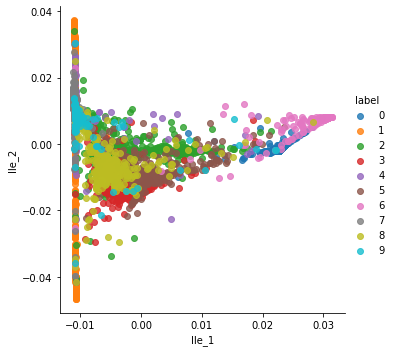

In [ ]:
X_train_lle=pd.DataFrame(X_train_lle).loc[:,0:1]
X_train_lle=pd.concat((X_train_lle, y_train), axis=1) 
X_train_lle.columns=['lle_1', 'lle_2', 'label']
X_train_lle

sns.lmplot(x='lle_1',y='lle_2',data=X_train_lle,hue='label',fit_reg=False)
plt.show()

## t-SNE
- 주변 이웃들과의 확률적 관계를 그대로 유지해주는 저차원의 공간을 찾자

In [ ]:
from sklearn.manifold import TSNE
start=time.time()
tsne = TSNE(n_components=2, random_state=42) #4미만의 공간으로
X_train_tsne = tsne.fit_transform(X_train)
print(f'{time.time()-start:.4f}sec')

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


77.4994sec


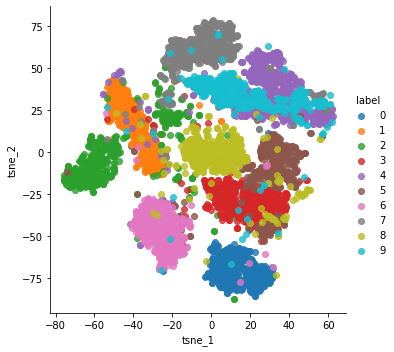

In [ ]:
X_train_tsne=pd.DataFrame(X_train_tsne).loc[:,0:1]
X_train_tsne=pd.concat((X_train_tsne, y_train), axis=1) 
X_train_tsne.columns=['tsne_1', 'tsne_2', 'label']
X_train_tsne

sns.lmplot(x='tsne_1',y='tsne_2',data=X_train_tsne,hue='label',fit_reg=False)
plt.show()